# Sub-Seasonal Temperature Forecasting in the United States.

##### Authors: Fridah Kimathi 

### **Importing the required libraries**

In [1]:
# importing pandas for data wrangling and manipulation
import pandas as pd

# numpy for numerical operation and arrays
import numpy as np

# importing matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')


# Sklearn
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, FunctionTransformer, OrdinalEncoder
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

from xgboost import XGBRegressor

#### **Loading the data**

In [2]:
#load the train dataset
train_df = pd.read_csv('Data/train_data.csv')
train_df.head(2)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.0,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.9,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42


In [3]:
test_df = pd.read_csv('Data/test_data.csv')
test_df.head(2)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,375734,0.0,0.833333,11/1/22,339.88,30.88,30.92,29.17,31.02,29.47,...,-19.28,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27
1,375735,0.0,0.833333,11/2/22,334.63,30.88,30.92,29.17,31.02,29.47,...,-19.58,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16


# **Data Understanding**

There are two datasets used in the project:
- train_data.csv: the training dataset, where contest-tmp2m-14d__tmp2m, the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, is provided
- test_data.csv: the test dataset, where the true value of contest-tmp2m-14d__tmp2m for each row is not provided.

In [4]:
# number of rows and columns
print(f'Shape of train data: {train_df.shape}')
print(f'Shape of test data: {test_df.shape}')

Shape of train data: (375734, 246)
Shape of test data: (31354, 245)


In [5]:
# summary of train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: float64(240), int64(4), object(2)
memory usage: 705.2+ MB


In [6]:
# summary of test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31354 entries, 0 to 31353
Columns: 245 entries, index to wind-vwnd-925-2010-20
dtypes: float64(241), int64(2), object(2)
memory usage: 58.6+ MB


In [7]:
#column names of train_df
train_df.columns

Index(['index', 'lat', 'lon', 'startdate',
       'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30',
       'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30',
       'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20',
       ...
       'wind-vwnd-925-2010-11', 'wind-vwnd-925-2010-12',
       'wind-vwnd-925-2010-13', 'wind-vwnd-925-2010-14',
       'wind-vwnd-925-2010-15', 'wind-vwnd-925-2010-16',
       'wind-vwnd-925-2010-17', 'wind-vwnd-925-2010-18',
       'wind-vwnd-925-2010-19', 'wind-vwnd-925-2010-20'],
      dtype='object', length=246)

In [8]:
# Printing out the target column name:

for col in train_df.columns:
    if col not in test_df.columns:
        print(f'{col}, Datatype: {train_df[col].dtype}')

contest-tmp2m-14d__tmp2m, Datatype: float64


In [9]:
# columns of dtype object
train_df.select_dtypes(include='object').head(2)

,startdate,climateregions__climateregion
0,9/1/14,BSh
1,9/2/14,BSh


In [10]:
# unique values of columns with dtype int64

for col in train_df.select_dtypes(include='int64').columns:
    print(train_df[col].value_counts())
    print('*****************************************************')

2047      1
92792     1
96890     1
94843     1
84604     1
         ..
107934    1
109983    1
21920     1
23969     1
0         1
Name: index, Length: 375734, dtype: int64
*****************************************************
4    59110
3    50372
7    49344
1    47802
6    46260
2    43690
8    41120
5    38036
Name: mjo1d__phase, dtype: int64
*****************************************************
67    94062
66    78128
48    30326
37    22102
64    15934
63    15934
53    15934
47    15934
44    15934
61    15420
60    15420
51    15420
49    15420
56     9766
Name: mei__meirank, dtype: int64
*****************************************************
4    291438
3     84296
Name: mei__nip, dtype: int64
*****************************************************


The target variable is the the arithmetic mean of the max and min observed temperature over the next 14 days for each location, and start date: 'contest-tmp2m-14d__tmp2m'.

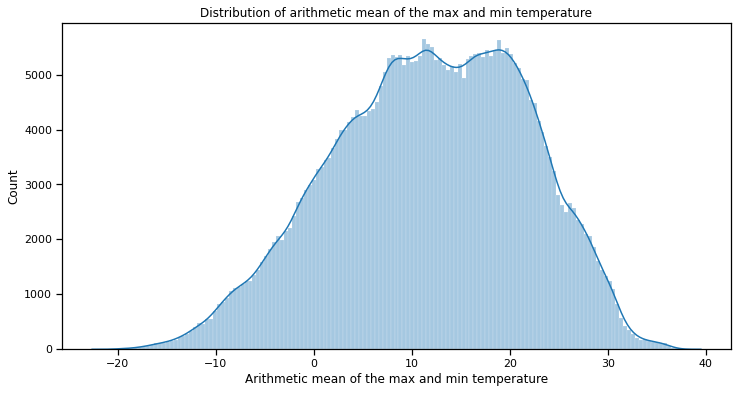

In [11]:
# Distribution of target variable - 'contest-tmp2m-14d__tmp2m'
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(train_df['contest-tmp2m-14d__tmp2m'], kde=True, kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
ax.set_title('Distribution of arithmetic mean of the max and min temperature')
ax.set_xlabel('Arithmetic mean of the max and min temperature');

The arithmetic mean temperature is between -20 and 40. The temperature is normally distributed but slightly skewed to the left.

## Data Preparation

### Duplicates

In [12]:
# check for duplicates
train_df.duplicated().sum()

0

### Missing values

In [13]:
def is_missing(data):
    """ 
    A function that return columns with missing values
    """
    return {column:data[column].isnull().sum() for column in data.columns if data[column].isnull().sum()}

In [14]:
is_missing(train_df)

{'nmme0-tmp2m-34w__ccsm30': 15934,
 'nmme-tmp2m-56w__ccsm3': 10280,
 'nmme-prate-34w__ccsm3': 8738,
 'nmme0-prate-56w__ccsm30': 15934,
 'nmme0-prate-34w__ccsm30': 15934,
 'nmme-prate-56w__ccsm3': 10280,
 'nmme-tmp2m-34w__ccsm3': 8738,
 'ccsm30': 15934}

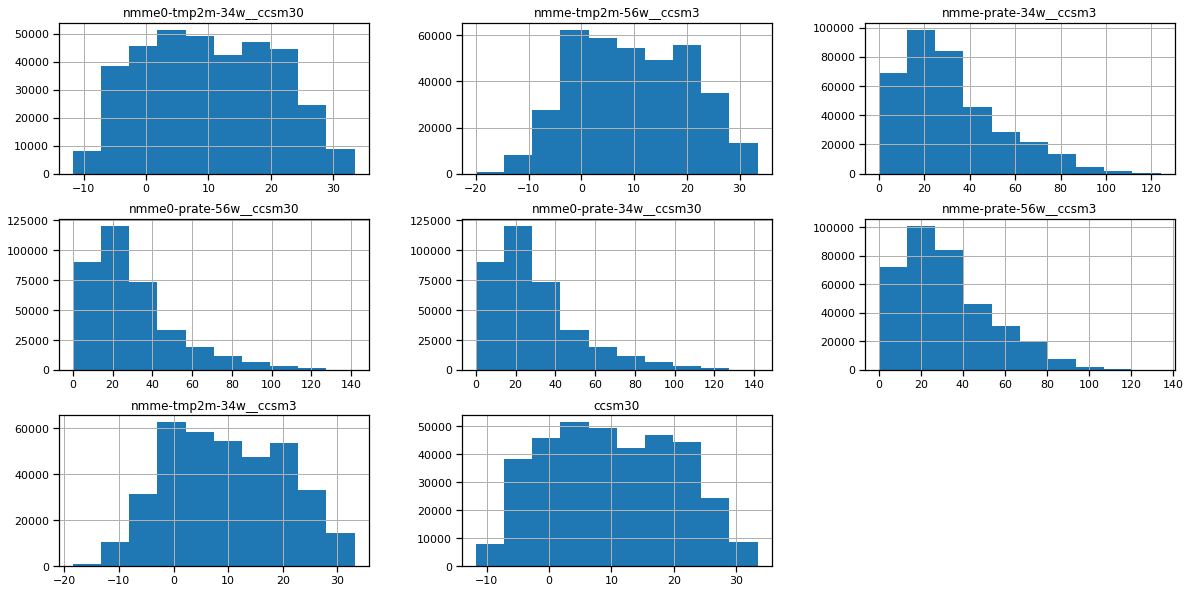

In [15]:
train_df[is_missing(train_df).keys()].hist(figsize=(20,10));

In [16]:
# The percentage of missing values per column
perc_missing = {col: round((val/train_df.shape[0])*100, 2) for col, val in is_missing(train_df).items()}
perc_missing

{'nmme0-tmp2m-34w__ccsm30': 4.24,
 'nmme-tmp2m-56w__ccsm3': 2.74,
 'nmme-prate-34w__ccsm3': 2.33,
 'nmme0-prate-56w__ccsm30': 4.24,
 'nmme0-prate-34w__ccsm30': 4.24,
 'nmme-prate-56w__ccsm3': 2.74,
 'nmme-tmp2m-34w__ccsm3': 2.33,
 'ccsm30': 4.24}

In [17]:
# The total percentage of missing values
(sum(is_missing(train_df).values())/train_df.shape[0])*100

# 27% of the data is missing.
# The missing values will be replaced with the median since majority of the data in these columns is skewed 

27.086183310533517

In [18]:
cols = list(is_missing(train_df).keys())
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
train_df[cols] = imp_median.fit_transform(train_df[cols])

In [19]:
#re-check for missing values in both dataframes

print(is_missing(train_df))
print(is_missing(test_df))

{}
{}


#### **Feature Engineering**
### Add new features - 'startdate' column

Convert startdate from dtype object to datetime, and add new feature “month” 

In [20]:
def create_time_features(df):
    df['startdate'] = pd.to_datetime(df['startdate'])
    df['month'] = df.startdate.dt.month
    df['day_of_year'] = train_df.startdate.dt.day
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)
train_df.head(2)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,month,day_of_year
0,0,0.0,0.833333,2014-09-01,237.0,29.02,31.64,29.57,30.73,29.71,...,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,9,1
1,1,0.0,0.833333,2014-09-02,228.9,29.02,31.64,29.57,30.73,29.71,...,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,9,2


In [21]:
train_df['month'].value_counts()

12    31868
10    31868
8     31868
7     31868
5     31868
3     31868
1     31868
11    30840
9     30840
6     30840
4     30840
2     29298
Name: month, dtype: int64

In [22]:
def seasons(data):
  """ 
  function for adding seasons to the dataset:
  winter(1): Dec, Jan, Feb
  Spring(2): March, April, May
  Summer(3): June, July, August
  Autumn(4): Sep, Oct, Nov

  """
  month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
  data['season'] = data['month'].apply(lambda x: month_to_season[x])

seasons(train_df)
seasons(test_df)

Sine and Cosine Encoding

In [23]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [24]:
def encode_cyclical(df):
  # encode the day with a period of 365
  df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
  df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])

  # encode the month with a period of 12
  df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
  df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

  # encode the season with a period of 4
  df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
  df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(train_df)
encode_cyclical(test_df)

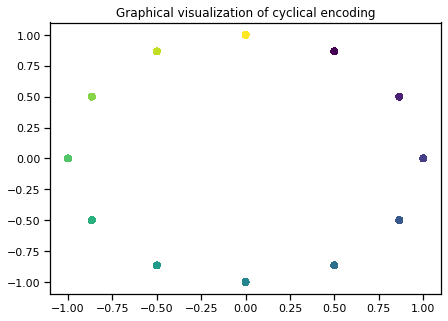

In [25]:
all_data = pd.concat([train_df, test_df])
fig, ax = plt.subplots(figsize=(7, 5))
plt.title("Graphical visualization of cyclical encoding")
ax.scatter(all_data["month_sin"], all_data["month_cos"], c=all_data["month"]);

In [26]:
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()

    # The mask is used to ensure duplicates are not shown
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # dataframe with no duplicates
    reduced_corr_matrix = corr_matrix.mask(mask)

    # Columns to drop
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [27]:
X_train = train_df.drop(['contest-tmp2m-14d__tmp2m', 'startdate'], axis=1)
y_train = train_df['contest-tmp2m-14d__tmp2m']
X_test = test_df.drop('startdate', axis=1)

In [28]:
to_drop =  identify_correlated(X_train, 0.8)
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

In [29]:

encoder_scaler = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(), make_column_selector(dtype_include=object)), ('scaler', StandardScaler(), make_column_selector(dtype_exclude=object))], remainder='passthrough')
X_train = encoder_scaler.fit_transform(X_train)
X_test = encoder_scaler.transform(X_test)

## Modelling

In [30]:
baseline_xgboost = XGBRegressor()
baseline_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [31]:
solutions2 = pd.DataFrame()
solutions2['contest-tmp2m-14d__tmp2m'] = baseline_xgboost.predict(X_test)
solutions2['index'] = test_df['index']
solutions2.to_csv('Solutions/solutions2.csv', index = False)
solutions2.head(3)

,contest-tmp2m-14d__tmp2m,index
0,28.637417,375734
1,28.724438,375735
2,28.734037,375736


In [33]:
xgboost_2 = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgboost_2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [35]:
solutions2 = pd.DataFrame()
solutions2['contest-tmp2m-14d__tmp2m'] = xgboost_2.predict(X_test)
solutions2['index'] = test_df['index']
solutions2.to_csv('Solutions/solutions2.csv', index = False)
solutions2.head(3)

,contest-tmp2m-14d__tmp2m,index
0,29.289585,375734
1,29.442024,375735
2,29.287081,375736
